In [79]:
import pandas as pd
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
from math import floor
import mplfinance as mpf


In [80]:
# Step 1: Fetch data
ticker = "ACA"
start_date = "2016-01-01"
end_date = "2023-12-31"
aapl = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [81]:
aapl.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,83.000000,83.769997,82.930000,83.419998,83.367081,162500
2023-12-26,83.559998,84.209999,83.432999,83.620003,83.566956,261600
2023-12-27,83.900002,84.120003,83.370003,84.010002,83.956711,143000
2023-12-28,83.510002,84.070000,83.459999,83.580002,83.526978,128500
2023-12-29,83.400002,83.555000,82.309998,82.639999,82.587578,160400


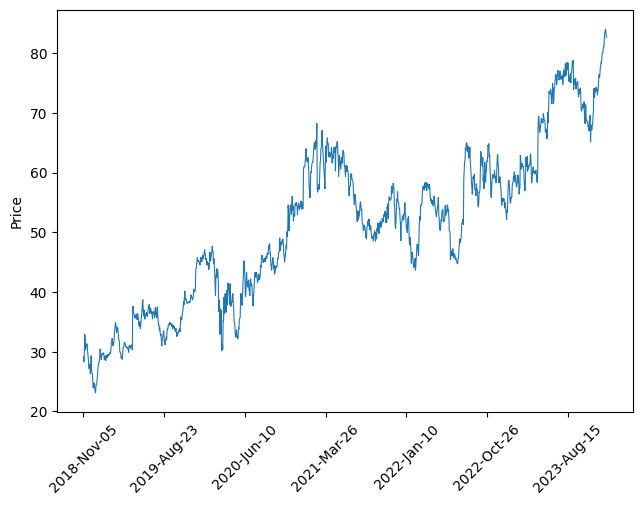

In [82]:
# Defining the market colors and styles for the mpf plots
market_colors = mpf.make_marketcolors(up='green', down='red', inherit=True)
mpf_style = mpf.make_mpf_style(marketcolors=market_colors)
# create the tick graph
mpf.plot(aapl, type = 'line', style=mpf_style)

In [83]:
short = 50
middle = 120
long = 200
def EMA_func (data, stock) :
    SEMA = data.Close.ewm(span=short, adjust=False).mean()
    MEMA = data.Close.ewm(span=middle, adjust=False).mean()
    LEMA = data.Close.ewm(span=long, adjust=False).mean()
    # Calculate EMA crossover signals
    ema_short = data['Close'].ewm(span=50, adjust=False).mean()
    ema_long = data['Close'].ewm(span=200, adjust=False).mean()
    buy_signal_ema = (ema_short > ema_long) & (ema_short.shift() < ema_long.shift())
    sell_signal_ema = (ema_short < ema_long) & (ema_short.shift() > ema_long.shift())
    data['Short_EMA'] = SEMA
    data['Middle_EMA'] = MEMA
    data['Long_EMA'] = LEMA
    plt.figure(figsize=(16,8))
    plt.title(stock + ' EMA', fontsize = 20)
    plt.plot(data['Close'], label = 'Close Price')
    plt.plot(data['Short_EMA'], label='Fast EMA', color = 'red')
    plt.plot(data['Middle_EMA'], label='Medium EMA', color = 'orange')
    plt.plot(data['Long_EMA'], label='Slow EMA', color = 'green')
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.legend(loc='best')
    plt.show()

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_RSI(data):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def RSI_func(data, stock):
    RSI = calculate_RSI(data["Close"])
    plt.figure(figsize=(16,8))
    plt.title(stock + ' RSI data', fontsize=20)
    plt.plot(data.index, [30] * len(data.index), label="oversold")
    plt.plot(data.index, [70] * len(data.index), label="overbought")
    plt.plot(data.index, RSI, label="RSI")
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('RSI Index', fontsize=18)
    plt.legend(loc='best')
    plt.show()
    data['RSI'] = RSI
    data['RSI_Section'] = pd.cut(RSI, bins=[-float("inf"), 30, 70, float("inf")], labels=['Oversold', 'Normal', 'Overbought'])
    return data
    


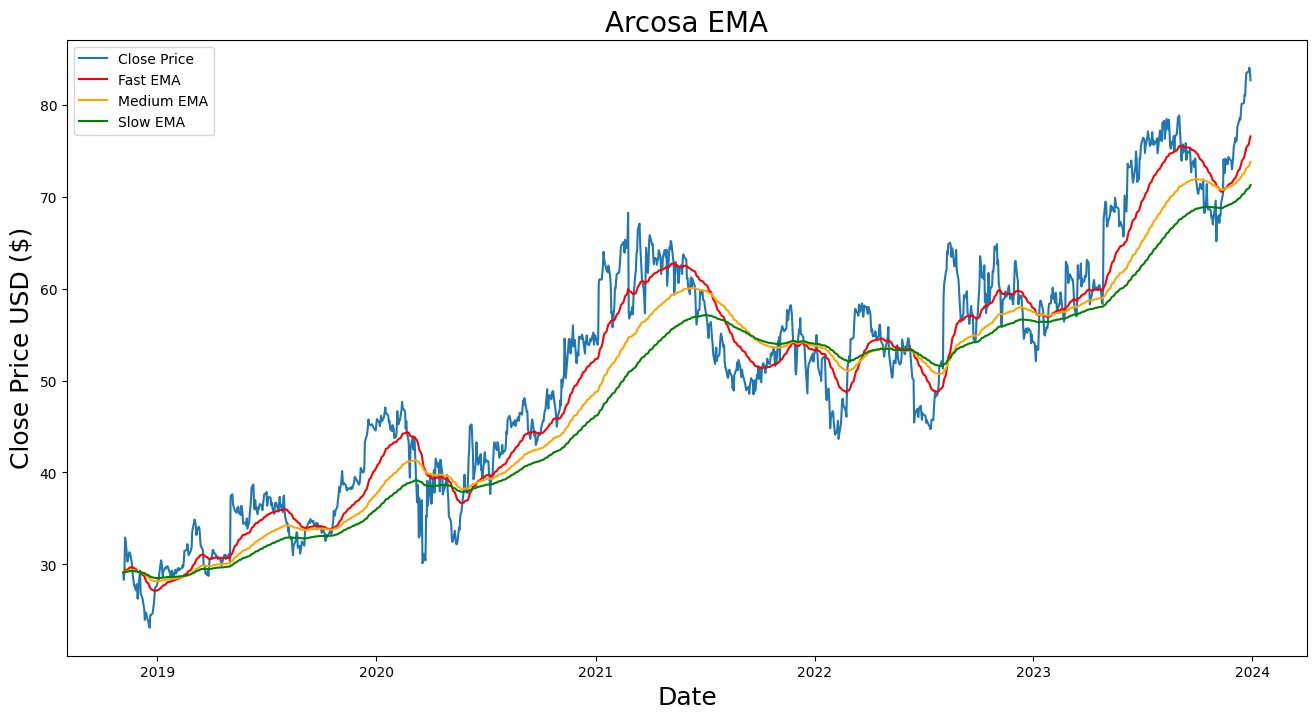

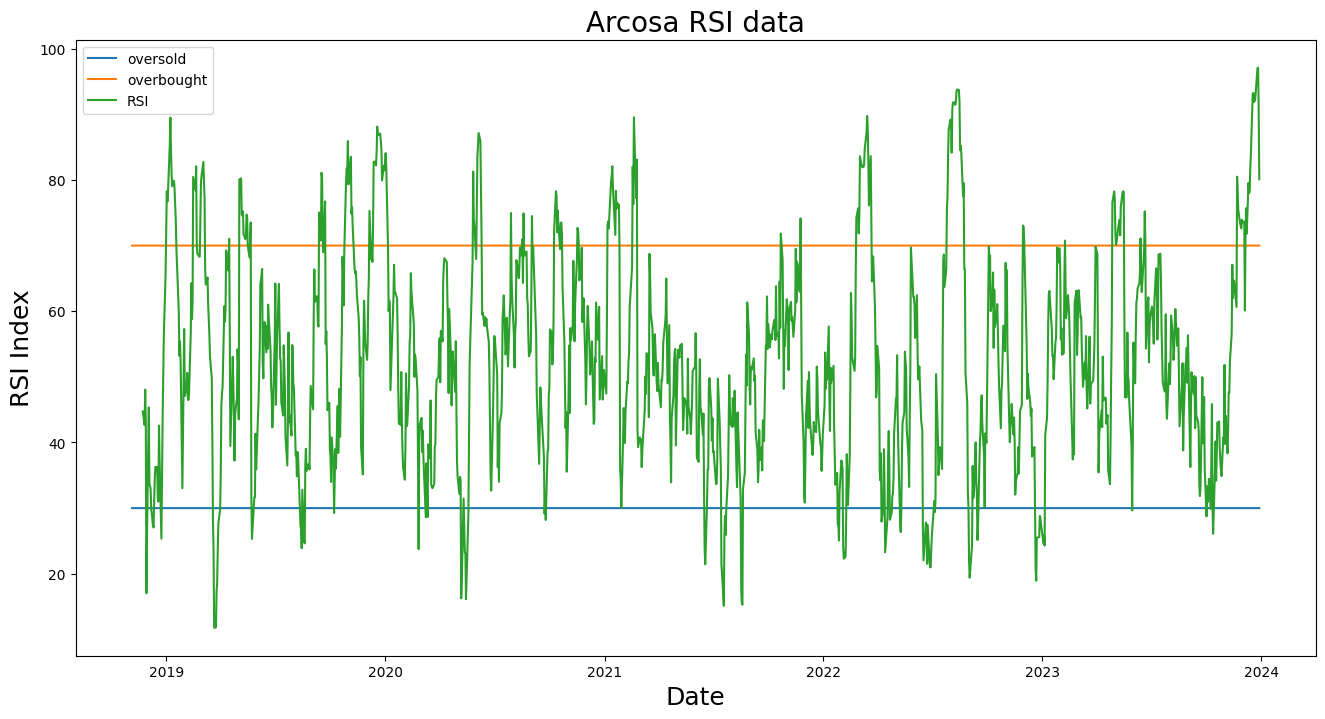

In [85]:
for i in [(aapl, 'Arcosa')]:
    EMA_func(i[0], i[1])
    RSI_func(i[0], i[1])

In [86]:
# STOCHASTIC OSCILLATOR CALCULATION
def stochastic_oscillator(data, k_lookback, d_lookback):
    lowest_low = data['Low'].rolling(window=k_lookback).min()
    highest_high = data['High'].rolling(window=k_lookback).max()
    data['%K'] = ((data['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    data['%D'] = data['%K'].rolling(window=d_lookback).mean()
    return data

In [87]:
# MACD CALCULATION
def macd(data, slow, fast, smooth):
    exp1 = data['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal Line'] = data['MACD'].ewm(span=smooth, adjust=False).mean()
    data['Histogram'] = data['MACD'] - data['Signal Line']
    return data

In [88]:

# STRATEGY: VOLUME MOMENTUM
def volume_momentum_strategy(data, volume_lookback):
    data['Volume Change'] = data['Volume'].pct_change(periods=volume_lookback)
    data['Signal'] = np.where(data['Volume Change'] > 0, 1, 0)  # Buy signal if volume is increasing
    return data


In [89]:
# TRADING STRATEGY
def implement_stoch_macd_strategy(prices, k, d, macd, macd_signal):    
    buy_price = []
    sell_price = []
    stoch_macd_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 30 and d[i] < 30 and macd[i] < 0 and macd_signal[i] < 0:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
                
        elif k[i] > 70 and d[i] > 70 and macd[i] > 0 and macd_signal[i] > 0:
            if signal != -1 and signal != 0:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_macd_signal.append(0)
        
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_macd_signal.append(0)
            
    return buy_price, sell_price, stoch_macd_signal

In [90]:
# IMPLEMENT STRATEGY
data = volume_momentum_strategy(aapl, volume_lookback=5)
data = stochastic_oscillator(data, k_lookback=9, d_lookback=5)
data = macd(data, slow=26, fast=12, smooth=9)

buy_price, sell_price, stoch_macd_signal = implement_stoch_macd_strategy(data['Close'], data['%K'], data['%D'], data['MACD'], data['Signal Line'])



C:\Users\Drishti garj\AppData\Local\Temp\ipykernel_72096\1097424678.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if k[i] < 30 and d[i] < 30 and macd[i] < 0 and macd_signal[i] < 0:
C:\Users\Drishti garj\AppData\Local\Temp\ipykernel_72096\1097424678.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif k[i] > 70 and d[i] > 70 and macd[i] > 0 and macd_signal[i] > 0:
C:\Users\Drishti garj\AppData\Local\Temp\ipykernel_72096\1097424678.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

In [91]:
# INITIAL INVESTMENT
initial_investment = 10000  # $10,000

# POSITION SIZE
position_size = initial_investment / data['Close'][0]

# CALCULATING PORTFOLIO VALUE
portfolio_value = position_size * data['Close']

C:\Users\Drishti garj\AppData\Local\Temp\ipykernel_72096\1109714230.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position_size = initial_investment / data['Close'][0]


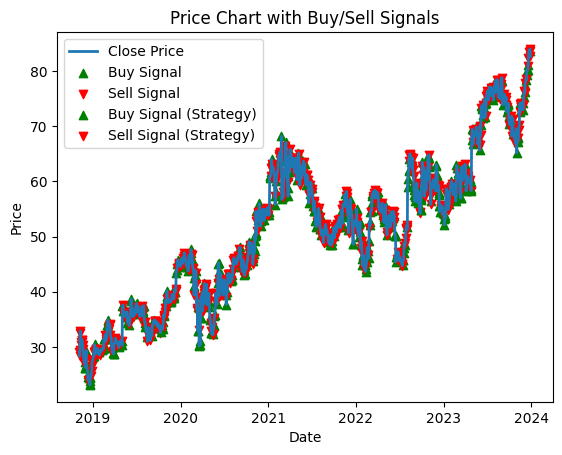

In [92]:
# PLOTTING PRICE AND BUY/SELL SIGNALS
plt.plot(data.index, data['Close'], label='Close Price', linewidth=2)
plt.scatter(data[data['Signal'] == 1].index, data[data['Signal'] == 1]['Close'], marker='^', color='g', label='Buy Signal')
plt.scatter(data[data['Signal'] == 0].index, data[data['Signal'] == 0]['Close'], marker='v', color='r', label='Sell Signal')
plt.scatter(data.index, buy_price, marker='^', color='g', label='Buy Signal (Strategy)')
plt.scatter(data.index, sell_price, marker='v', color='r', label='Sell Signal (Strategy)')
plt.title('Price Chart with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [93]:
# CREATE LOGS FOR BUY/SELL SIGNALS
logs = pd.DataFrame({
    'Date': data.index,
    'Buy Signal': buy_price,
    'Sell Signal': sell_price,
    'Stoch MACD Signal': stoch_macd_signal
})
logs['Position'] = np.where(logs['Stoch MACD Signal'] == 1, 'Buy', np.where(logs['Stoch MACD Signal'] == -1, 'Sell', 'Hold'))

# SAVE LOGS TO CSV
logs.to_csv('trading_logs.csv', index=False)

In [94]:
# TRADING STRATEGY RETURNS
data['Daily Returns'] = data['Close'].pct_change()
stoch_macd_series = pd.Series(stoch_macd_signal, index=data.index)
data['Strategy Returns'] = stoch_macd_series.shift(1) * data['Daily Returns']
data.dropna(inplace=True)


In [95]:
# CALCULATING METRICS
strategy_return = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0] * 100  # in percentage
annualized_return = strategy_return * 252 / len(data)  # Assuming 252 trading days in a year

C:\Users\Drishti garj\AppData\Local\Temp\ipykernel_72096\825671617.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_return = (portfolio_value[-1] - portfolio_value[0]) / portfolio_value[0] * 100  # in percentage


In [96]:
number_of_trades = sum(1 for signal in stoch_macd_signal if signal != 0)
max_drawdown = (data['Strategy Returns'].cumsum() - data['Strategy Returns'].cumsum().cummax()).min()
win_ratio = (data['Strategy Returns'] > 0).sum() / number_of_trades if number_of_trades != 0 else np.nan
loss_making_trades = (data['Strategy Returns'] < 0).sum()
largest_loss_making_trade = data['Strategy Returns'].min()
largest_profit_making_trade = data['Strategy Returns'].max()
daily_return = data['Strategy Returns'].mean()
sharpe_ratio = daily_return / data['Strategy Returns'].std() * np.sqrt(252)
total_return = (data['Strategy Returns'] + 1).prod() - 1

In [97]:
print("Summary:")

print(f"Number of Trades Executed: {number_of_trades}")
print(f"Max Drawdown: {max_drawdown}")
print(f"Win Ratio: {win_ratio}")
print(f"Loss Making Trades: {loss_making_trades}")
print(f"Largest Loss Making Trade: {largest_loss_making_trade}")
print(f"Largest Profit Making Trade: {largest_profit_making_trade}")
print(f"Daily Return: {daily_return}")
print(f"sharpe ratio: {sharpe_ratio}")
print(f"Total Return: {total_return}")

Summary:
Number of Trades Executed: 24
Max Drawdown: -0.027286106394836862
Win Ratio: 0.7916666666666666
Loss Making Trades: 5
Largest Loss Making Trade: -0.023546361542204686
Largest Profit Making Trade: 0.12906164471951143
Daily Return: 0.00034449927609776705
sharpe ratio: 1.1444493798924689
Total Return: 0.5342705042290208


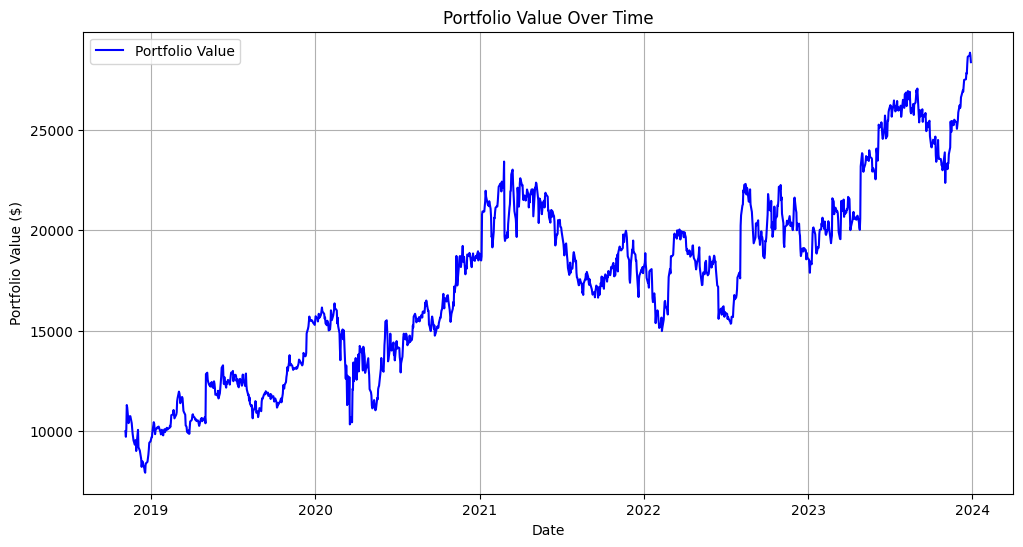

In [98]:
# PLOTTING PORTFOLIO VALUE OVER TIME
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio Value', color='blue')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
